In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Introduction to AI and OpenVino
## Session 00 - Template

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###------------------
### Import statements
###------------------

import sys
import os
from time import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler



In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.1
N_SAMPLES = 1000
ALPHA = 0.001

# parameters for Matplotlib
params = {'legend.fontsize': 'small',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.2
EPOCHS=20000

<Figure size 1500x500 with 0 Axes>

## Helper Function

In [4]:
###-----------------------
### plot decision boundary
###-----------------------

def fn_plot_decision_boundary(pred_func, X, y, ax = None):
    '''
        Attrib:
           pred_func : function based on predict method of 
                    the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    if ax is None:
        ax = plt.gca()
        
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.05
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)
    
    # plot the points as well
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=CMAP, edgecolors='black')

In [5]:
###---------------------------
### plot svc Decision Function
###---------------------------
def fn_plot_svc_decision_function(clf):
    
    """Plot the decision function for a 2D SVC"""
    
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    
    Y, X = np.meshgrid(y, x)
    
    P = np.zeros_like(X)
    
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            #print (clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0])
            P[i, j] = clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0]
    return plt.contour(X, Y, P, colors='k',
                       levels=[-1, 0, 1],
                       linestyles=['--', '-', '--'])

In [6]:
###---------------------------------------
### Function to plot Loss Curve tensorflow
###---------------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes 
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [7]:
from sklearn.svm import SVC
from sklearn.datasets import make_blobs

clf = SVC (kernel='linear')

X, y = make_blobs(n_samples=50, centers=2, random_state=RANDOM_STATE, cluster_std=0.60)
clf.fit(X,y)

SVC(kernel='linear')

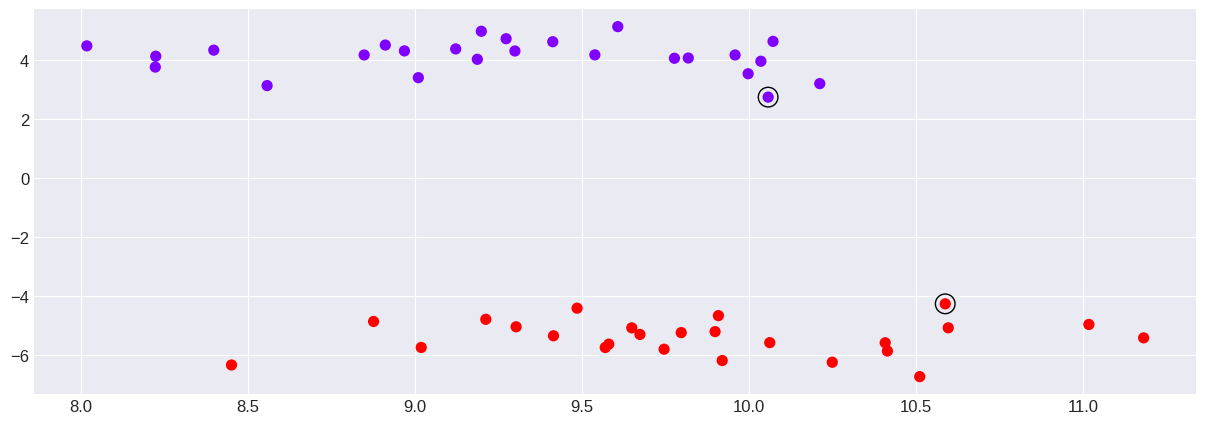

In [8]:
plt.scatter(X[: , 0], X[: , 1], c=y, s=50, cmap=CMAP)
plt.scatter(clf.support_vectors_[:,0],
            clf.support_vectors_[:, 1],s=200,edgecolors='k',facecolor='None')

In [ ]:
input_dim =X_train.shape[1]
output_dim = y_train.shape[1]
num_hdim=4

w1 = np.random.rand(input_dim, num_hdim)
b1 = np.zeros((1, num_hdim))

w2 = np.random.rand(num_hdim, output_dim)/np.sqrt
b2 = np.zeros(1, output_dim)

w1.shape, b1.shape, w2.shape, b2.shape

In [11]:
def fn_sigmoid(z):
    return 1/ (1+np.exp(-z))

In [12]:
fn_sigmoid(np.array([-np.inf, -10, np.inf]))

array([0.00000000e+00, 4.53978687e-05, 1.00000000e+00])

In [13]:
def fn_activ(z):
    return np.tanh(z)

def fn_activ_prime(a):
    return 1.0 - np.tanh(a)**2

In [14]:
fn_activ(np.array([-np.inf, -10, 0, 10, np.inf]))

array([-1., -1.,  0.,  1.,  1.])

In [ ]:
Ssum_error = 0
loss = []
epoch = []
for ep in np.arange(EPOCHS):
    Z1 = X.dot(W1) +b1
    a1 = fn_activ(Z1)
    
    
    z2= a1.dot(w2)+b2
    a2 = fn_activ(z2)
    
    dz2= a2-y
    assert(z2.shape == dz2.shape), f'Error:z2 {z2.shape}/{dz2.shape}'